In [1]:
from voltron.robinhood_utils import GetStockData
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd

import gpytorch
from torch.nn.functional import softplus
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP

In [2]:
import os
import robin_stocks.robinhood as r

# Header

In [3]:
ntest = 100
ntrain = 500
tckrs = ['TSLA', "F", "JPM", "SBUX", 'AAPL', "VIRT"]
tckr = "SPY"
span = "3month"
interval = 'hour'
T = 5.

## Data Setup

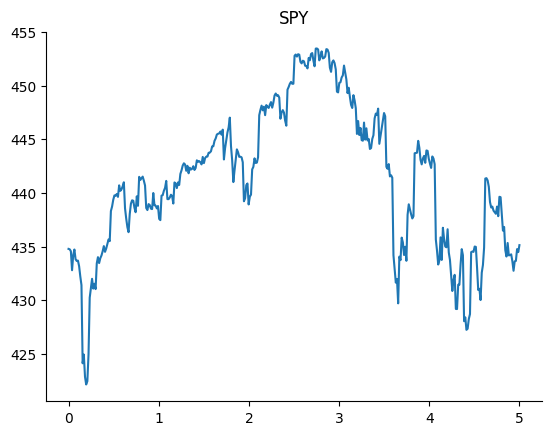

In [4]:
idx = -2
data = GetStockData(tckr, span=span, interval=interval)

ts = torch.linspace(0, T, data.shape[0])
train_x = ts[:ntrain]
test_x = ts[ntrain:(ntrain+ntest)]

y = torch.FloatTensor(data['close_price'].to_numpy())
train_y = y[:ntrain]
test_y = y[ntrain:(ntrain+ntest)]

dt = ts[1] - ts[0]

plt.plot(train_x, train_y)
plt.plot(test_x, test_y)
plt.title(tckr);
sns.despine()
plt.show()

## Model Setup

### Learn Train Vol Path

In [168]:
garch = arch_model(np.log(train_y[1:]/train_y[:-1]), q=1, p=1).fit()
v = (garch.conditional_volatility/np.sqrt(dt))
vlog = v.log().float()
# v = vlog.exp()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 141119365.63998526
Iteration:      2,   Func. Count:     18,   Neg. LLF: 67039164.31986434
Iteration:      3,   Func. Count:     30,   Neg. LLF: 31901095.64321779
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1.0718228553175738e+17
Iteration:      5,   Func. Count:     55,   Neg. LLF: 67236.99966236952
Iteration:      6,   Func. Count:     64,   Neg. LLF: -1473.3917800663248
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1473.3917726261616
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 6


/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.557e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


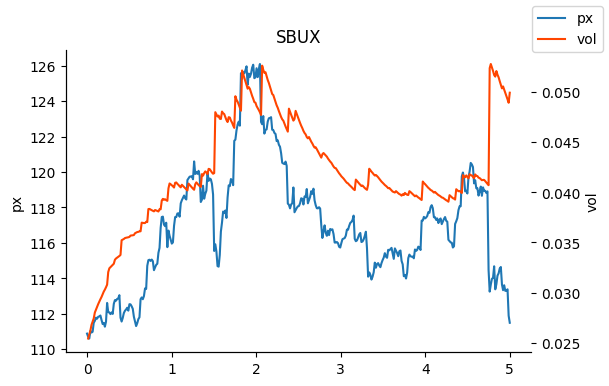

In [169]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.plot(train_x, train_y, label='px')
ax2 = ax.twinx()
ax2.plot(train_x[1:], v, color='OrangeRed', label="vol")
sns.despine()
fig.legend()
ax.set_title(tckr)
ax.set_ylabel("px")
ax2.set_ylabel("vol")
plt.show()

## Train Latent GP

In [130]:
vol_lh = gpytorch.likelihoods.GaussianLikelihood()
vol_lh.noise.data = torch.tensor([1e-6])
vol_model = BMGP(train_x[:-1], vlog, vol_lh)

optimizer = torch.optim.Adam([
    {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = vol_model(train_x[:-1])
    # Calc loss and backprop gradients
    loss = -mll(output, vlog)
    loss.backward()
#     print(loss.item(), model.covar_module.vol.item())
    optimizer.step()
    
print(softplus(vol_model.covar_module.raw_vol))
print(vol_model.mean_module.constant.data.exp())

tensor([1.5353], grad_fn=<SoftplusBackward>)
tensor([0.3422])


## Train Data GP

In [106]:
voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
voltron = VoltronGP(train_x[:-1], train_y[:-1].log(), voltron_lh, v)
voltron.likelihood.raw_noise.data = torch.tensor([1e-6])
voltron.vol_lh = vol_lh
voltron.vol_model = vol_model

In [107]:
grad_flags = [False, True, True, True, False, False, False]

for idx, p in enumerate(voltron.parameters()):
    p.requires_grad = grad_flags[idx]

In [110]:
nvol = 10
npx = 10
vol_paths = torch.zeros(nvol, ntest)
px_paths = torch.zeros(npx*nvol, ntest)

voltron.vol_model.eval();
voltron.eval();

for vidx in range(nvol):
    print(vidx)
    vol_pred = voltron.vol_model(test_x).sample().exp()
    vol_paths[vidx, :] = vol_pred.detach()
    
    px_pred = voltron.GeneratePrediction(test_x, vol_pred, npx).exp()
    px_paths[vidx*npx:(vidx*npx+npx), :] = px_pred.detach().T

0
1
2
3
4
5
6
7
8
9


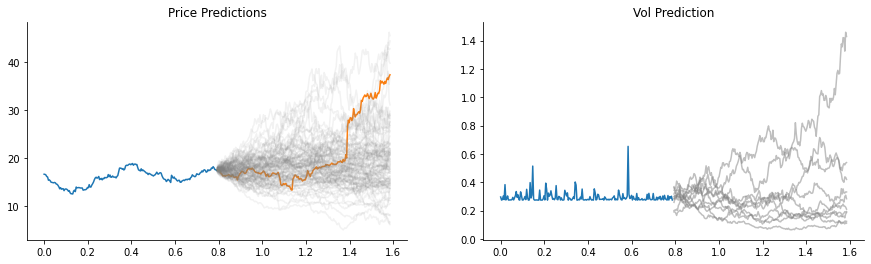

In [111]:
fig, ax = plt.subplots(1,2,figsize=(15, 4))

ax[0].set_title("Price Predictions")
ax[0].plot(train_x, train_y)
ax[0].plot(test_x, test_y)
ax[0].plot(test_x, px_paths.T, c='gray', alpha=0.1)
# ax[0].set_ylim(50, 150)
# ax[0].axvline(2., c='OrangeRed')
sns.despine()


ax[1].set_title("Vol Prediction")
ax[1].plot(train_x[:-1], voltron.log_vol_path.exp().detach())
ax[1].plot(test_x, vol_paths.T, c='gray', alpha=0.5)
sns.despine()
plt.show()